In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, precision_score, f1_score, plot_confusion_matrix



In [2]:
epileptic = pd.read_csv("Epileptic Seizure Recognition.csv", index_col='Unnamed')
epileptic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11500 entries, X21.V1.791 to X16.V1.210
Columns: 179 entries, X1 to y
dtypes: int64(179)
memory usage: 15.8+ MB


In [3]:
# Select the independent variable and identify the dependent variables
X = epileptic.drop(columns='y')
y = epileptic.y

#Split data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8050, 178) (8050,)
(3450, 178) (3450,)


In [4]:
# count of each response in training set
def data_dist(data, data_type):
    response_list = [1, 2, 3, 4, 5]
    res_count = []
    for y in response_list:
        print(y, data[data == y].count())
        a = data[data == y].count()
    res_count.append(a)

    
    # chart the data 
    plt.bar(response_list, height=res_count)
    
    if data_type == 'train':
        # add title
        plt.title('Training Responses')


    elif data_type == 'test':
        # add title
        plt.title('Testing Responses')
        
    # add axis names
    plt.ylabel('response')
    plt.xlabel('count')
    # show graph
    plt.show()

In [5]:
# train and fit data 
def pos_proba(clf, X_train, y_train, X_test):
    #scale the data 
    clf_pipe = make_pipeline(StandardScaler(), clf)

    # Fit the model on the training data
    clf_pipe.fit(X_train, y_train)

    # Probability that a particular data point falls into the underlying class
    y_pred = clf_pipe.predict_proba(X_test)

    #Shape y_pred in 1D shape
    flat_ypred = np.argmax(y_pred, axis = 1)

    return clf_pipe, y_pred, flat_ypred  

In [6]:
def classOpVal(y_test, y_pred, flat_ypred, clf_pipe):
    # Calculate AUROC
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr', labels=clf_pipe.classes_)

    # Calculate ROC curve 
    r_fpr, r_tpr, _ = roc_curve(y_test, flat_ypred, pos_label=clf_pipe.classes_[0])
    
    return auc, r_fpr, r_tpr

In [7]:
def evaluation_metrics(cls_list, rows, cols, str_cls):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
    a = 0
    for cls, ax in zip(cls_list, axes.flatten()):
        # LogisticRegression confusion matrices with class probabilities
        lr_cm = plot_confusion_matrix(cls[0],
                                      X_test, 
                                      y_test,
                                      ax=ax,
                                      labels=cls[0].classes_,
                                      display_labels=cls[0].classes_,
                                      cmap='Blues'
                                     )
    
    

        # LogisticRegression classification threshold
        lr_auc, lr_fpr, lr_tpr = classOpVal(y_test, cls[2], cls[3], cls[1])
    
        lr_f1 = f1_score(y_test, 
                         cls[3], 
                         pos_label=1, 
                         average='macro', 
                         sample_weight=None, 
                         zero_division='warn')
        if str_cls == 'lr': 
            # Add title
            ax.title.set_text(''.join(['solver:',str(cls[5]),
                                       ' c:',str(cls[4]),
                                       ' AUROC:',str(round(lr_auc,4)),
                                       ' f1:', str(round(lr_f1,4))]))
        elif str_cls == 'rf':
            # Add title
            ax.title.set_text(''.join(['criterion:',str(cls[5]),
                                       ' max_features:',str(cls[6]),
                                       ' oob score:', str(round(cls[4],4)),
                                       ' AUROC:',str(round(lr_auc,4)),
                                       ' f1:', str(round(lr_f1,4))]))
        elif str_cls == 'ab':
            # Add title
            ax.title.set_text(''.join(['n_estimators:',str(cls[5]),
                                       ' learning rate:',str(cls[4]),
                                       ' AUROC:',str(round(lr_auc,4)),
                                       ' f1:', str(round(lr_f1,4))]))
        elif str_cls == 'sgd':
            # Add title
            ax.title.set_text(''.join(['penalty:',str(cls[4]),
                                       ' loss:',str(cls[5]),
                                       ' AUROC:',str(round(lr_auc,4)),
                                       ' f1:', str(round(lr_f1,4))]))
                
        
    plt.tight_layout()
    plt.show()

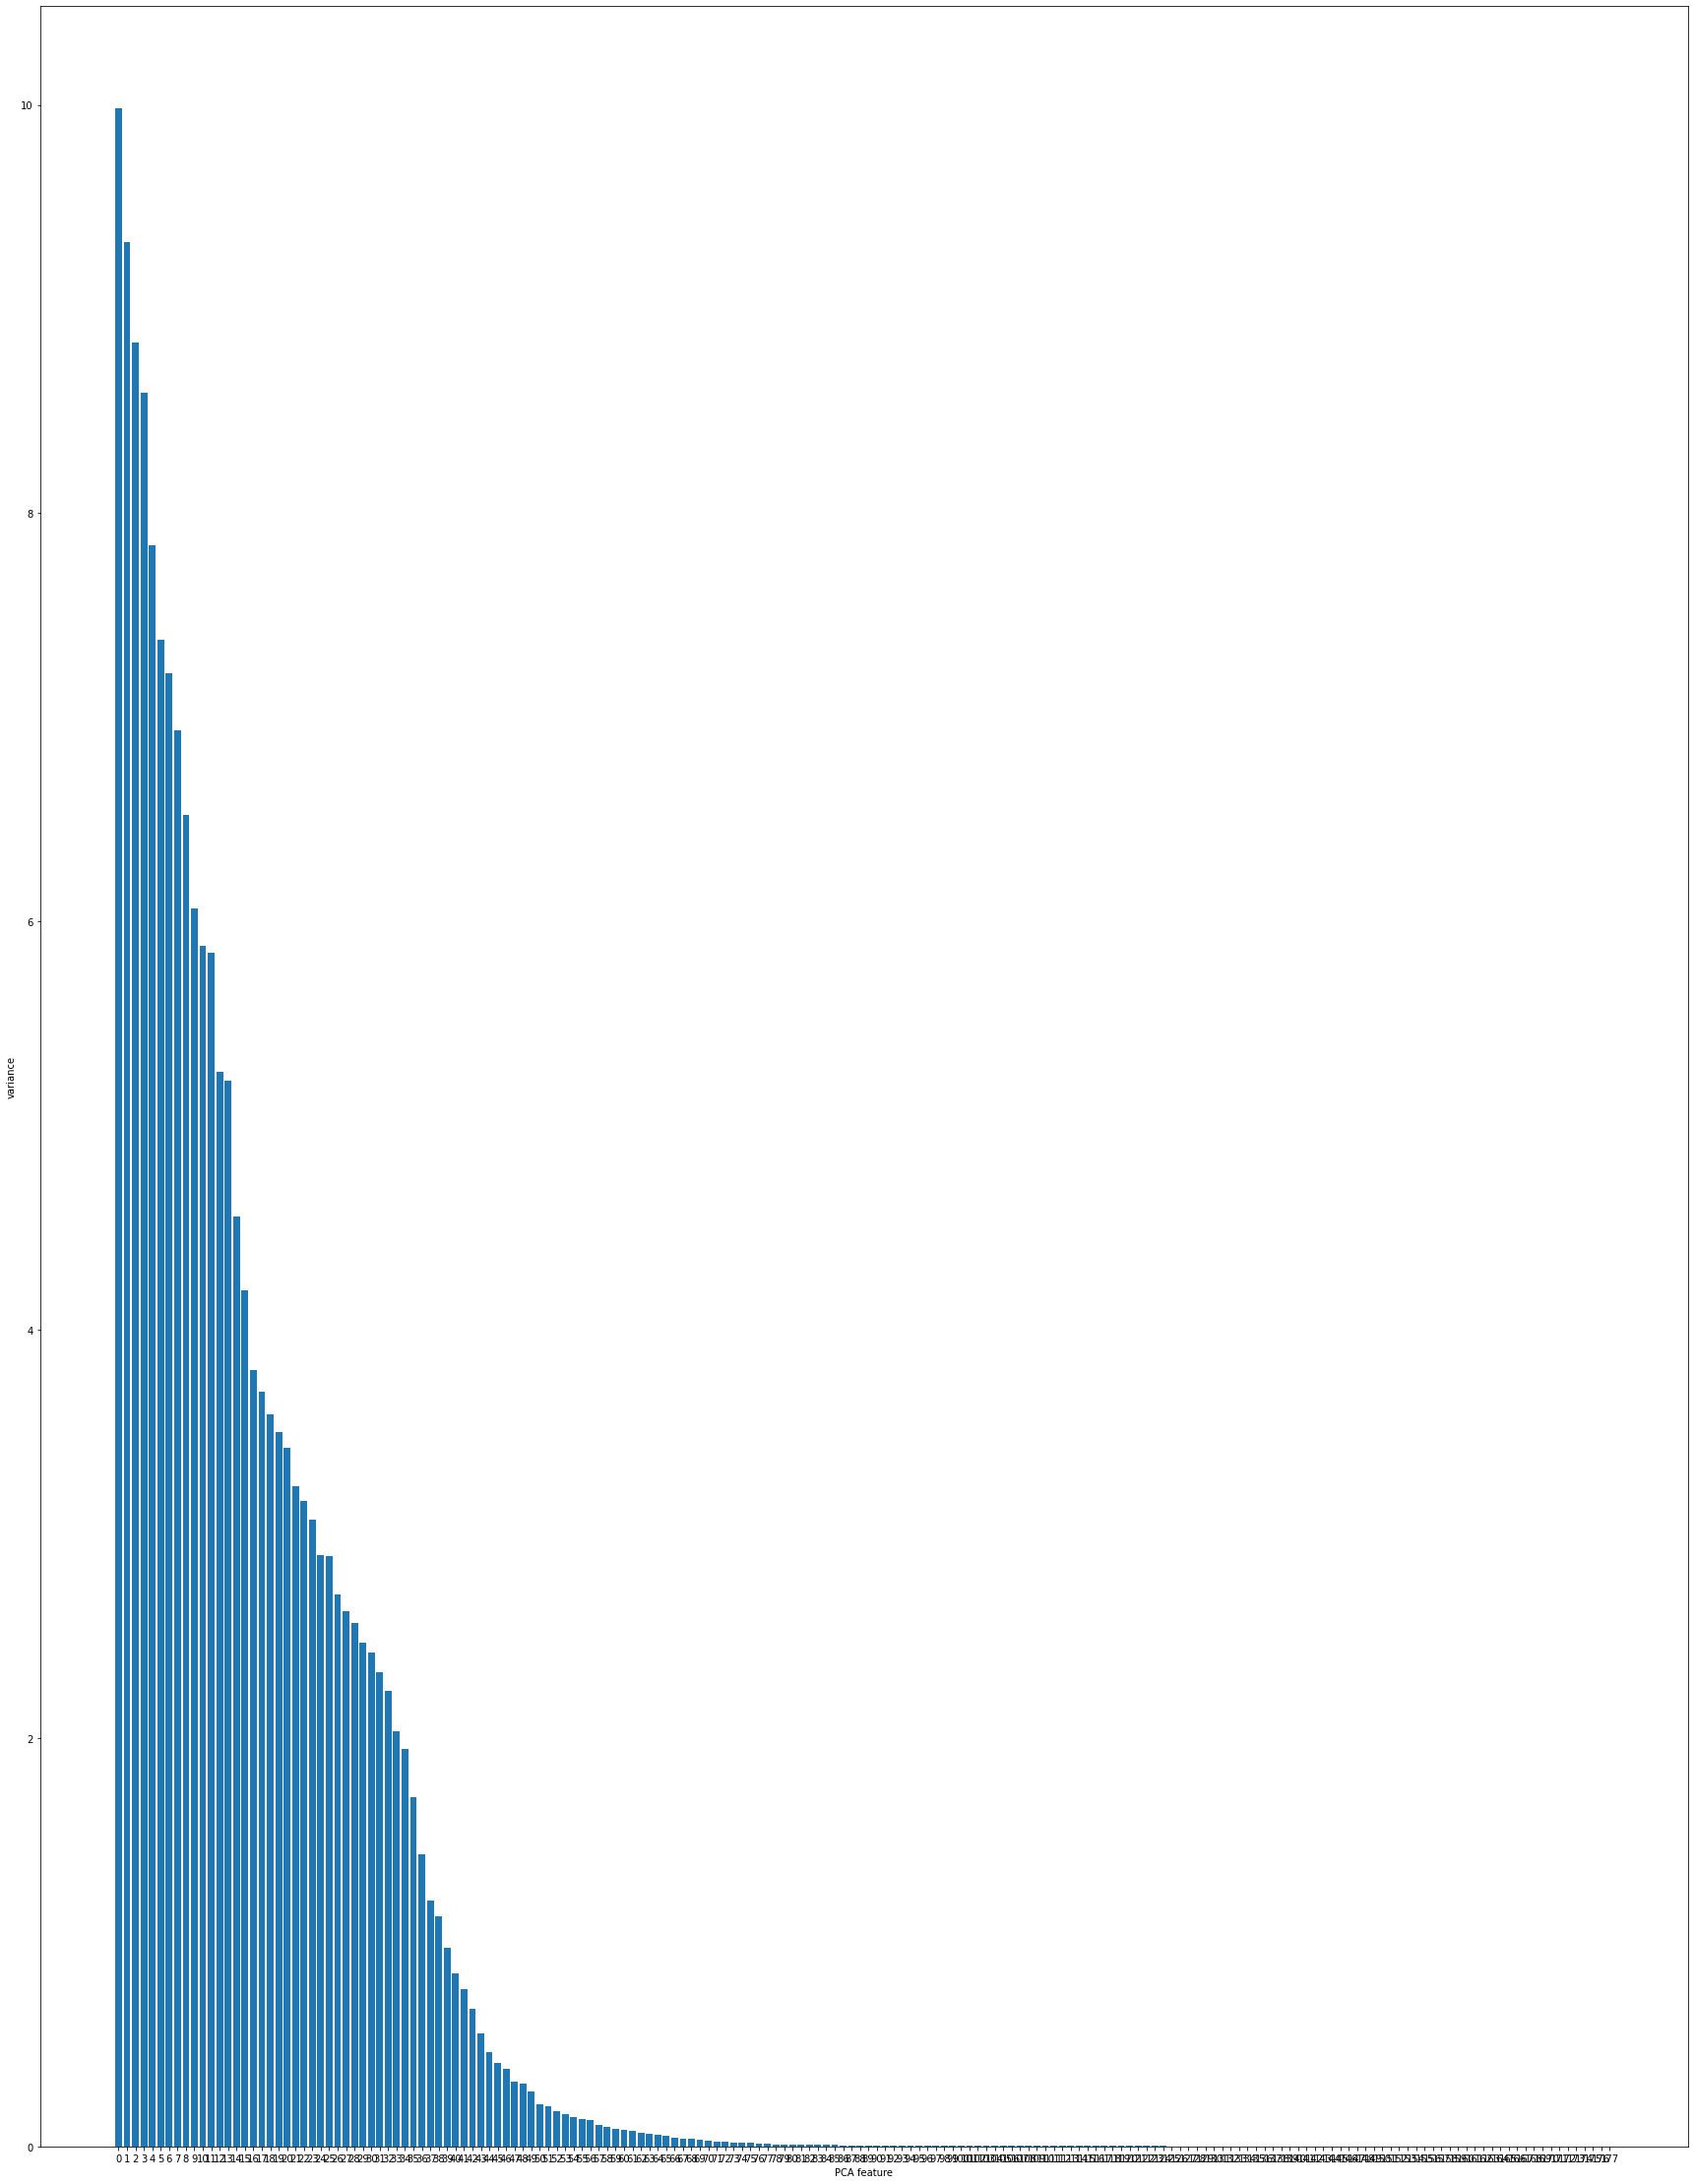

In [8]:
# Rows of transformed correspond to sampels 
# Colunms of transformed are the "PCA features"

# Create Scaler 
scaler = StandardScaler()

# Create PCA instance 
pca = PCA()

# Create pipeline
pipeline = make_pipeline(scaler, pca)

# Fit pipeline to samples 
pipeline.fit(X)

#Plot explained variance 
plt.figure(figsize=(30, 40))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

5 - eyes open, they were recording the EEG signal of the brain when the patient had their eyes open

4 - eyes closed, means they were recording the EEG signal of brain when the patient had their eyes closed

3 - They identified where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area

2 - They recorded the EEG from the area where the tumor was located

1 - Recording of seizure activity

1 1621
2 1599
3 1615
4 1607
5 1608


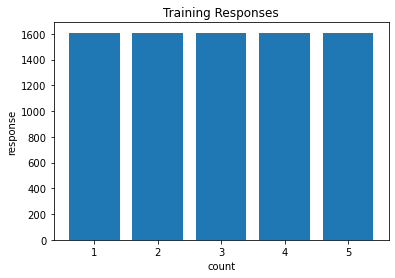

In [9]:
data_dist(y_train, 'train')

1 679
2 701
3 685
4 693
5 692


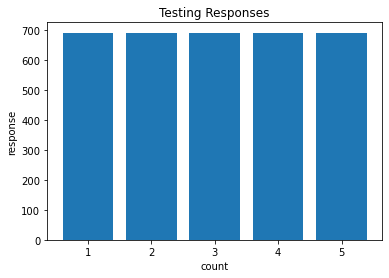

In [10]:
data_dist(y_test, 'test')

In [11]:
# Logistic regression hyperparemters 
c = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.005]

solver = ["newton-cg", "lbfgs", "sag", "saga"] 

In [12]:
#Optimizing Logistic Regression 
lr_list = []
lr_f1_list = []
lr_auroc_list = []
for i in range(8):
    for ii in range(4):
        lr = LogisticRegression(tol=0.1,
                                penalty='l2',
                                class_weight='balanced',
                                solver=solver[ii], 
                                C=c[i],
                                max_iter=100,
                                multi_class='multinomial',
                                verbose=False,
                                warm_start=False,
                                n_jobs=-1)
        
        # LogisticRegression class probabilities
        lr_pipe, lry_pred, lrflat_ypred = pos_proba(lr, X_train, y_train, X_test)
        lr_list.append([lr, lr_pipe, lry_pred, lrflat_ypred, c[i], solver[ii]])
        
        # Logistic Regression classification threshold
        lr_auc, lr_fpr, lr_tpr = classOpVal(y_test, lry_pred, lrflat_ypred, lr_pipe)
        lr_auroc_list.append(lr_auc)
        
        # Logistic Regression f1 score       
        lr_f1 = f1_score(y_test, lrflat_ypred, pos_label=1, average='macro', sample_weight=None, zero_division='warn')
        lr_f1_list.append(lr_f1)
        
        print(solver[ii], c[i], round(lr_auc,4), round(lr_f1,4))
        
max_lr_auc = max(lr_auroc_list)
min_lr_auc = min(lr_auroc_list)
print('best auroc',round(max_lr_auc,4), 'worst auroc' , round(min_lr_auc,4))
max_lr_f1 = max(lr_f1_list)
min_lr_f1 = min(lr_f1_list)
print('best f1', round(max_lr_f1,4), 'worst f1', round(min_lr_f1,4))



newton-cg 1.0 0.5402 0.1359
lbfgs 1.0 0.5403 0.1373
sag 1.0 0.5369 0.1241
saga 1.0 0.5367 0.1217
newton-cg 0.5 0.5417 0.1355
lbfgs 0.5 0.541 0.1331
sag 0.5 0.5384 0.1217
saga 0.5 0.5375 0.1208
newton-cg 0.1 0.5405 0.129
lbfgs 0.1 0.5404 0.1297
sag 0.1 0.5366 0.1213
saga 0.1 0.5378 0.1225
newton-cg 0.05 0.5397 0.1282
lbfgs 0.05 0.5397 0.1277
sag 0.05 0.5379 0.1207
saga 0.05 0.5373 0.1209
newton-cg 0.01 0.5382 0.1193
lbfgs 0.01 0.5382 0.1193
sag 0.01 0.5366 0.1184
saga 0.01 0.5372 0.1193
newton-cg 0.005 0.5379 0.1221
lbfgs 0.005 0.5379 0.1219
sag 0.005 0.5382 0.1204
saga 0.005 0.5373 0.1189
newton-cg 0.001 0.5359 0.1198
lbfgs 0.001 0.5359 0.1199
sag 0.001 0.5357 0.1176
saga 0.001 0.5355 0.1171
newton-cg 0.005 0.5379 0.1221
lbfgs 0.005 0.5379 0.1219
sag 0.005 0.5377 0.1221
saga 0.005 0.5374 0.1236
best auroc 0.5417 worst auroc 0.5355
best f1 0.1373 worst f1 0.1171


In [13]:
# Random Forest hyperparemters 
criterion = ["gini","entropy"]

max_features = ['sqrt', 'log2']

In [14]:
#Optimizing Random Forest 
rf_list = []
rf_auroc_list = []
rf_f1_list = []
for i in range(2):
    for ii in range(2):        
        #  Instatiate RandomForest classifier 
        rf = RandomForestClassifier(n_estimators=100,
                                    criterion=criterion[i],
                                    max_depth=None,
                                    min_samples_split=2,
                                    max_features=max_features[ii],
                                    bootstrap=True,
                                    oob_score=True,
                                    n_jobs=None,
                                    random_state=None,
                                    verbose=0,
                                    warm_start=False,
                                    class_weight='balanced',
                                    ccp_alpha=0.0,
                                    max_samples=None)


        # RandomForest class probabilities
        rf_pipe, rfy_pred, rfflat_ypred = pos_proba(rf, X_train, y_train, X_test)
        
        oob = rf.oob_score_
        oob_d = rf.oob_decision_function_
        
        rf_list.append([rf, 
                        rf_pipe, 
                        rfy_pred, 
                        rfflat_ypred, 
                        oob, 
                        criterion[i], 
                        max_features[ii]])
        
        # Random Forest classification threshold
        rf_auc, rf_fpr, rf_tpr = classOpVal(y_test, rfy_pred, rfflat_ypred, rf_pipe)
        rf_auroc_list.append(rf_auc)
        
        # RandomForest f1 score       
        rf_f1 = f1_score(y_test, rfflat_ypred, pos_label=1, average='macro', sample_weight=None, zero_division='warn')
        rf_f1_list.append(rf_f1)
        
        print(criterion[i], max_features[ii], round(rf_auc,4), round(rf_f1,4))
        
max_rf_auc = max(rf_auroc_list)
min_rf_auc = min(rf_auroc_list)
print('best auroc',round(max_rf_auc,4), 'worst auroc', round(min_rf_auc,4))
max_rf_f1 = max(rf_f1_list)
min_rf_f1 = min(rf_f1_list)
print('best f1', round(max_rf_f1,4), 'worst f1', round(min_rf_f1,4))


gini sqrt 0.9056 0.0952
gini log2 0.9051 0.09
entropy sqrt 0.9091 0.0935
entropy log2 0.9062 0.0976
best auroc 0.9091 worst auroc 0.9051
best f1 0.0976 worst f1 0.09


In [15]:
# AdaBoost hyperparemters 
n_estimators = [10, 50, 100, 500, 1000]

learning_rate = [3, 2, 1]

In [16]:
#Optimizing AdaBoost 
ab_list = []
ab_f1_list = []
ab_auroc_list = []
for i in range(3):
    for ii in range(5):        
        #  Instatiate AdaBoost classifier 
        ab = AdaBoostClassifier(n_estimators=n_estimators[ii], 
                                learning_rate=learning_rate[i], 
                                algorithm='SAMME.R', 
                                random_state=0)

        # AdaBoost class probabilities
        ab_pipe, aby_pred, abflat_ypred = pos_proba(ab, X_train, y_train, X_test)
        
        ab_list.append([ab, 
                        ab_pipe, 
                        aby_pred, 
                        abflat_ypred,  
                        learning_rate[i], 
                        n_estimators[ii]])
        
        # AdaBoost classification threshold
        ab_auc, ab_fpr, ab_tpr = classOpVal(y_test, aby_pred, abflat_ypred, ab_pipe)
        ab_auroc_list.append(ab_auc)
        
        # AdaBoost f1 score       
        ab_f1 = f1_score(y_test, abflat_ypred, pos_label=1, average='macro', sample_weight=None, zero_division='warn')
        ab_f1_list.append(ab_f1)
        
        print(n_estimators[ii], learning_rate[i], round(ab_auc,4), round(ab_f1,4))
        
max_ab_auc = max(ab_auroc_list)
min_ab_auc = min(ab_auroc_list)
print('best auroc',round(max_ab_auc,4), 'worst auroc', round(min_ab_auc,4))
max_ab_f1 = max(ab_f1_list)
min_ab_f1 = min(ab_f1_list)
print('best f1', round(max_ab_f1,4), 'worst f1', round(min_ab_f1,4))

10 3 0.5824 0.0954
50 3 0.5304 0.1156
100 3 0.5721 0.1557
500 3 0.6375 0.1298
1000 3 0.6498 0.1163
10 2 0.5864 0.0603
50 2 0.5863 0.0603
100 2 0.5863 0.0603
500 2 0.5863 0.0603
1000 2 0.5863 0.0603
10 1 0.6636 0.0925
50 1 0.6899 0.0945
100 1 0.6625 0.1029
500 1 0.702 0.0975
1000 1 0.7099 0.0987
best auroc 0.7099 worst auroc 0.5304
best f1 0.1557 worst f1 0.0603


In [17]:
# SGD hyperparemters 
sgd_penalty = ['l2','l1', 'elasticnet']

loss = ['log', 'modified_huber']

In [18]:
#Optimizing SGD
sgd_list = []
sgd_f1_list = []
sgd_auroc_list = []
for i in range(3):
    for ii in range(2):        
        #  Instatiate SGD classifier 
        sgd = SGDClassifier(loss=loss[ii],
                            penalty=sgd_penalty[i], 
                            alpha=0.0001, 
                            l1_ratio=0.15, 
                            fit_intercept=True, 
                            max_iter=1000, 
                            tol=0.001, 
                            shuffle=True, 
                            verbose=0, 
                            epsilon=0.1, 
                            n_jobs=-1, 
                            random_state=25, 
                            learning_rate='optimal', 
                            eta0=0.0, 
                            power_t=0.5, 
                            early_stopping=False, 
                            validation_fraction=0.1, 
                            n_iter_no_change=5, 
                            class_weight=None, 
                            warm_start=False, 
                            average=True)

        # SGD class probabilities
        sgd_pipe, sgdy_pred, sgdflat_ypred = pos_proba(sgd, X_train, y_train, X_test)
        
        sgd_list.append([sgd, 
                        sgd_pipe, 
                        sgdy_pred, 
                        sgdflat_ypred,  
                        sgd_penalty[i], 
                        loss[ii]])
        # SGD classification threshold
        sgd_auc, sgd_fpr, sgd_tpr = classOpVal(y_test, sgdy_pred, sgdflat_ypred, sgd_pipe)
        sgd_auroc_list.append(sgd_auc)
        
        # SGD f1 score       
        sgd_f1 = f1_score(y_test, sgdflat_ypred, pos_label=1, average='macro', sample_weight=None, zero_division='warn')
        sgd_f1_list.append(sgd_f1)
        
        print(sgd_penalty[i], loss[ii], round(sgd_auc,4), round(sgd_f1,4))
        
max_sgd_auc = max(sgd_auroc_list)
min_sgd_auc = min(sgd_auroc_list)
print('best auroc',round(max_sgd_auc,4), 'worst auroc', round(min_sgd_auc,4))
max_sgd_f1 = max(sgd_f1_list)
min_sgd_f1 = min(sgd_f1_list)
print('best f1', round(max_sgd_f1,4), 'worst f1', round(min_sgd_f1,4))

l2 log 0.5509 0.1327
l2 modified_huber 0.5191 0.0417
l1 log 0.5257 0.1288
l1 modified_huber 0.5142 0.0839
elasticnet log 0.524 0.1504
elasticnet modified_huber 0.5309 0.0882
best auroc 0.5509 worst auroc 0.5142
best f1 0.1504 worst f1 0.0417


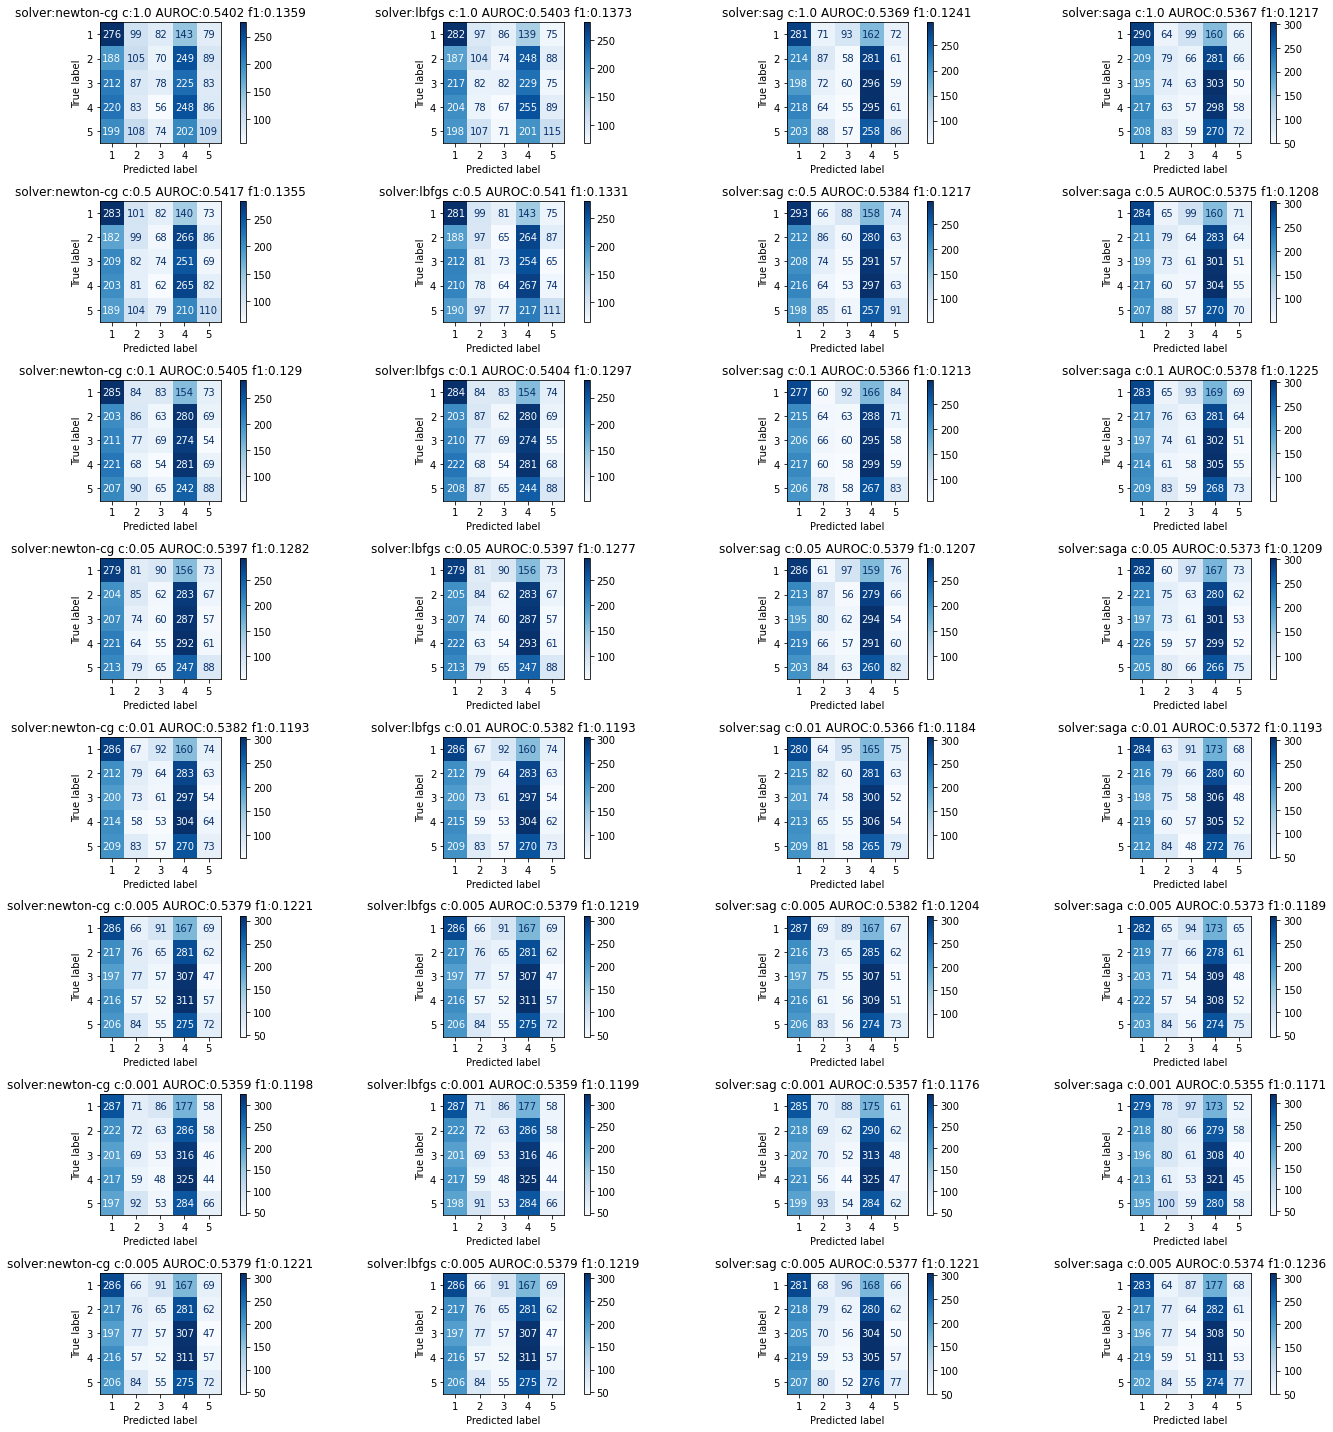

In [19]:
# Logistic Regression inferential
evaluation_metrics(lr_list, 8, 4, 'lr')

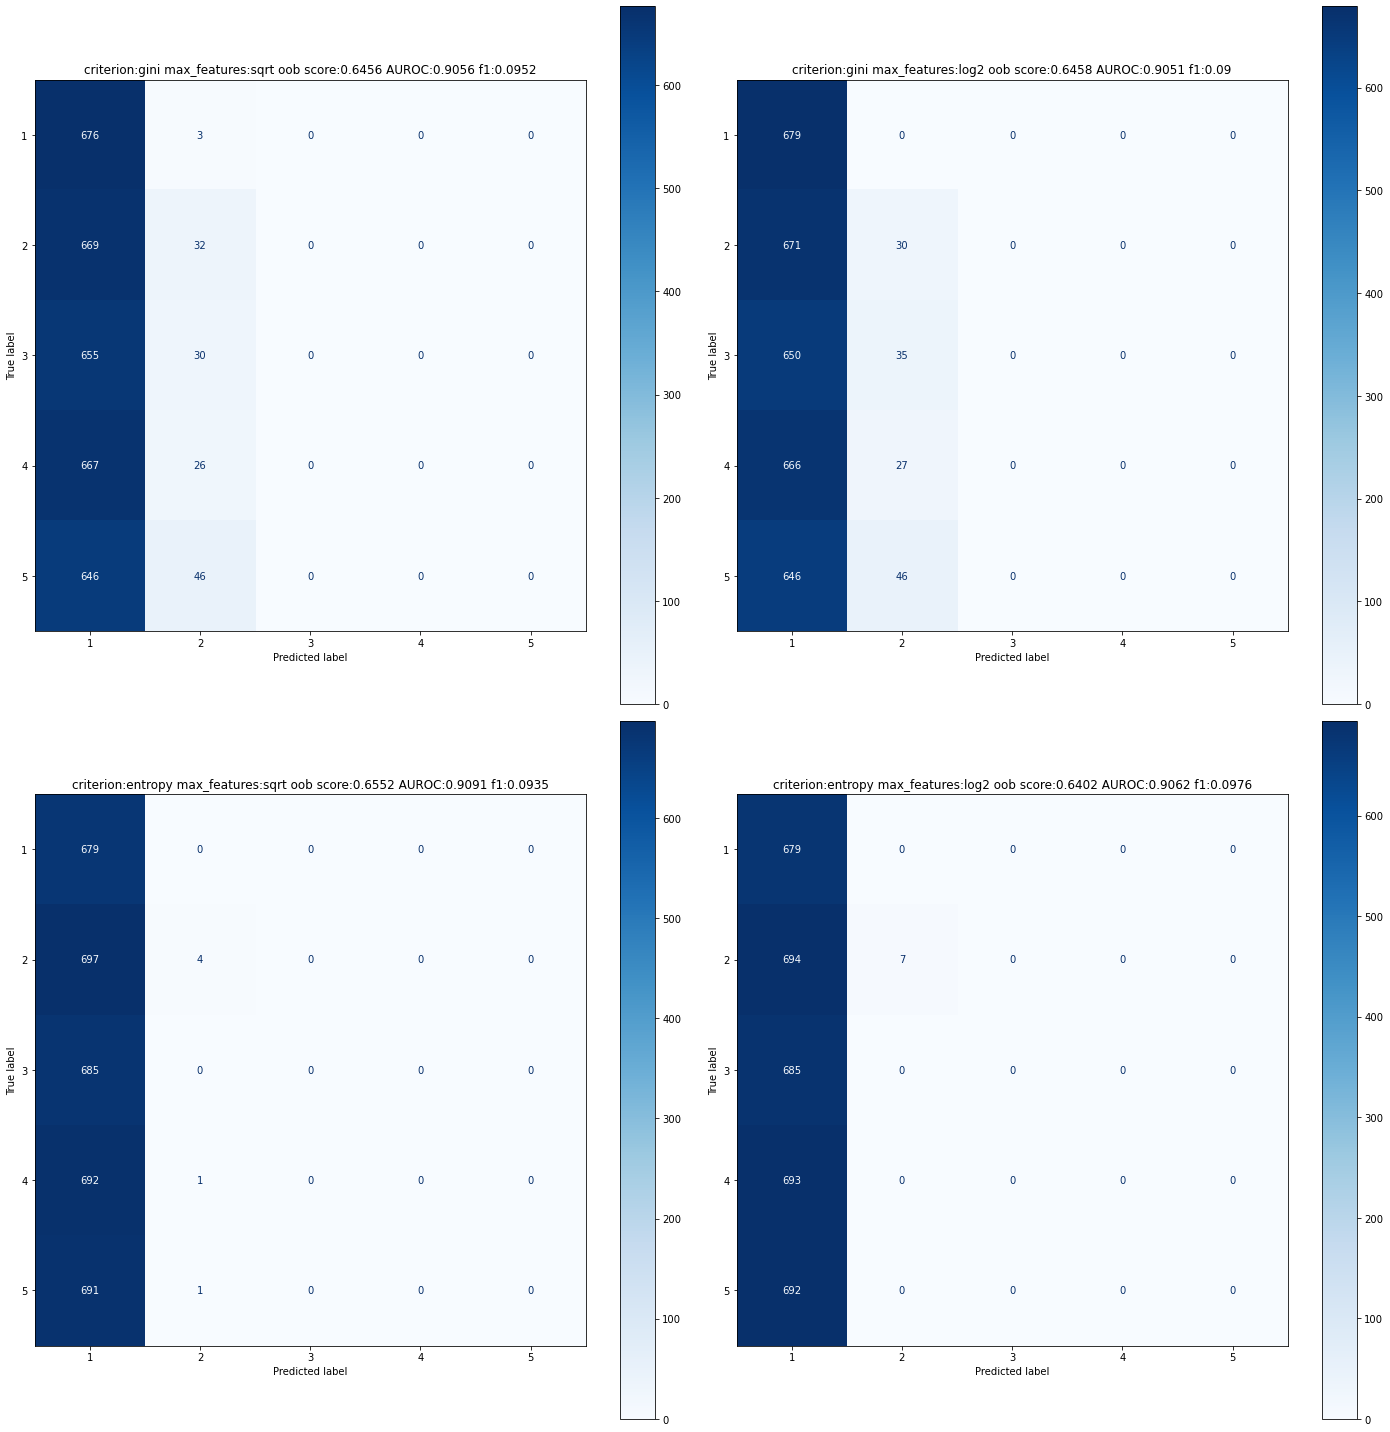

In [20]:
# Random Forest inferential 
evaluation_metrics(rf_list, 2, 2, 'rf')

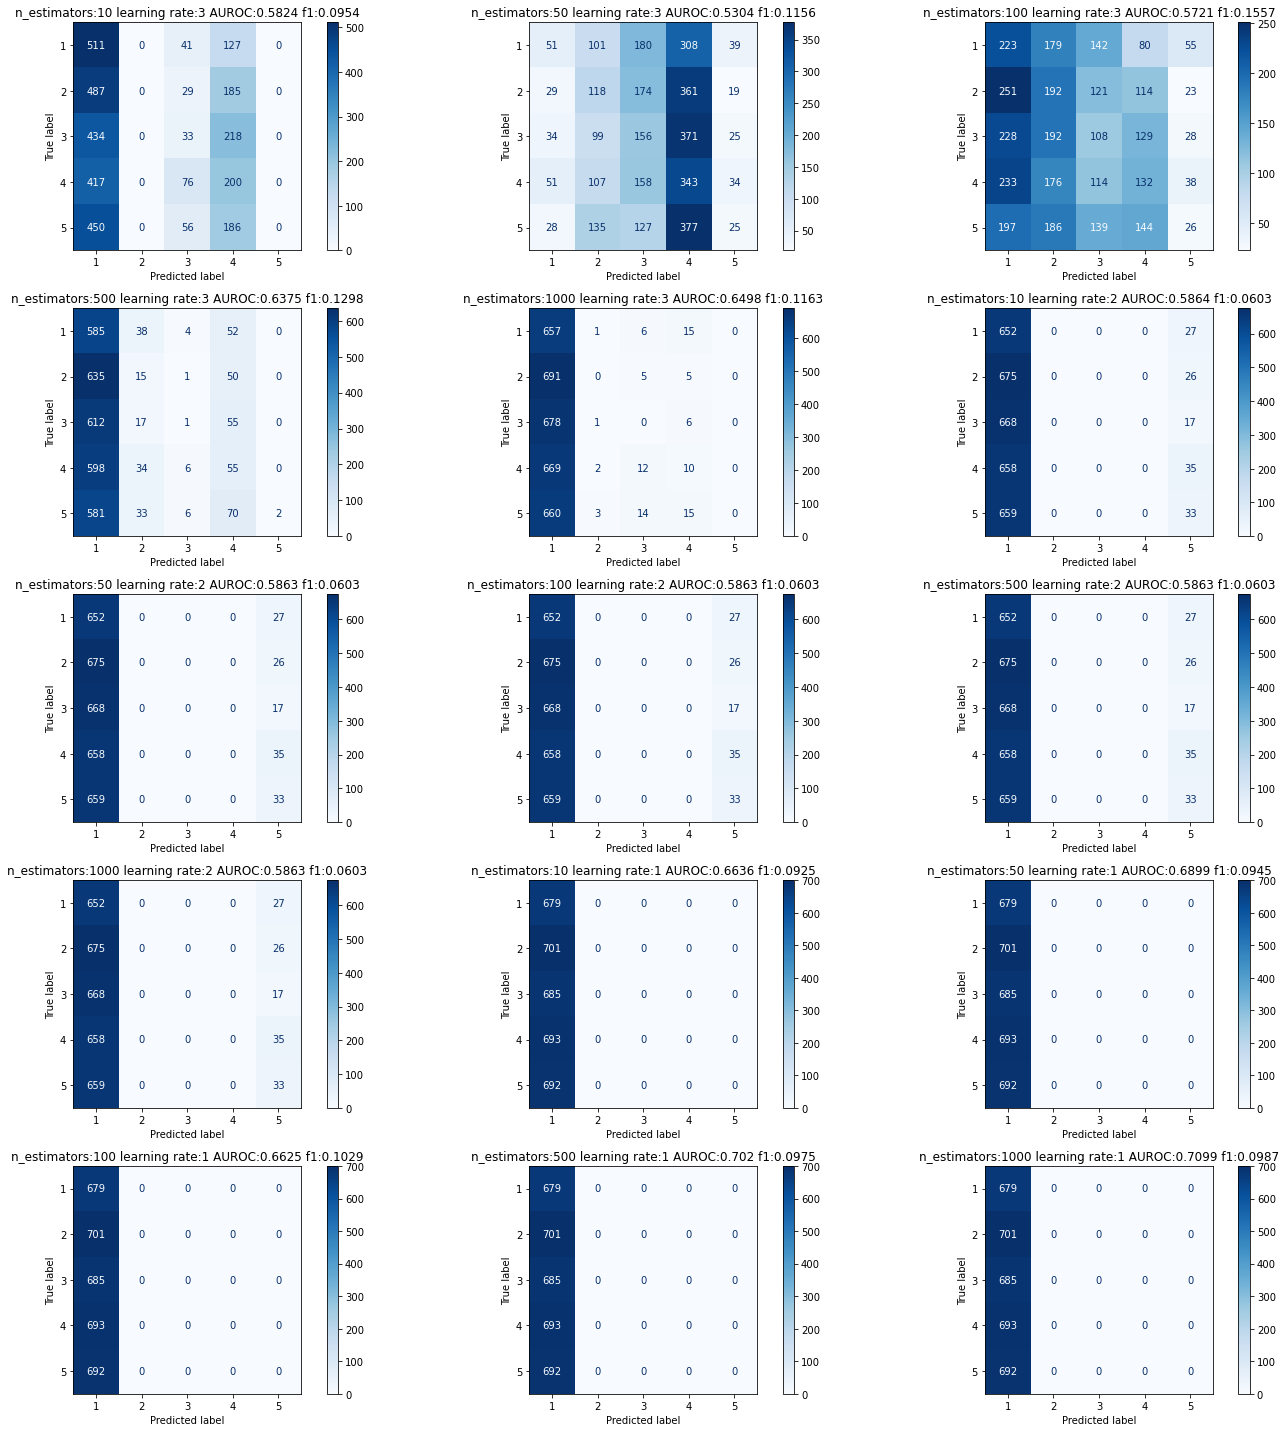

In [21]:
# AdaBoost inferential 
evaluation_metrics(ab_list, 5, 3, 'ab')

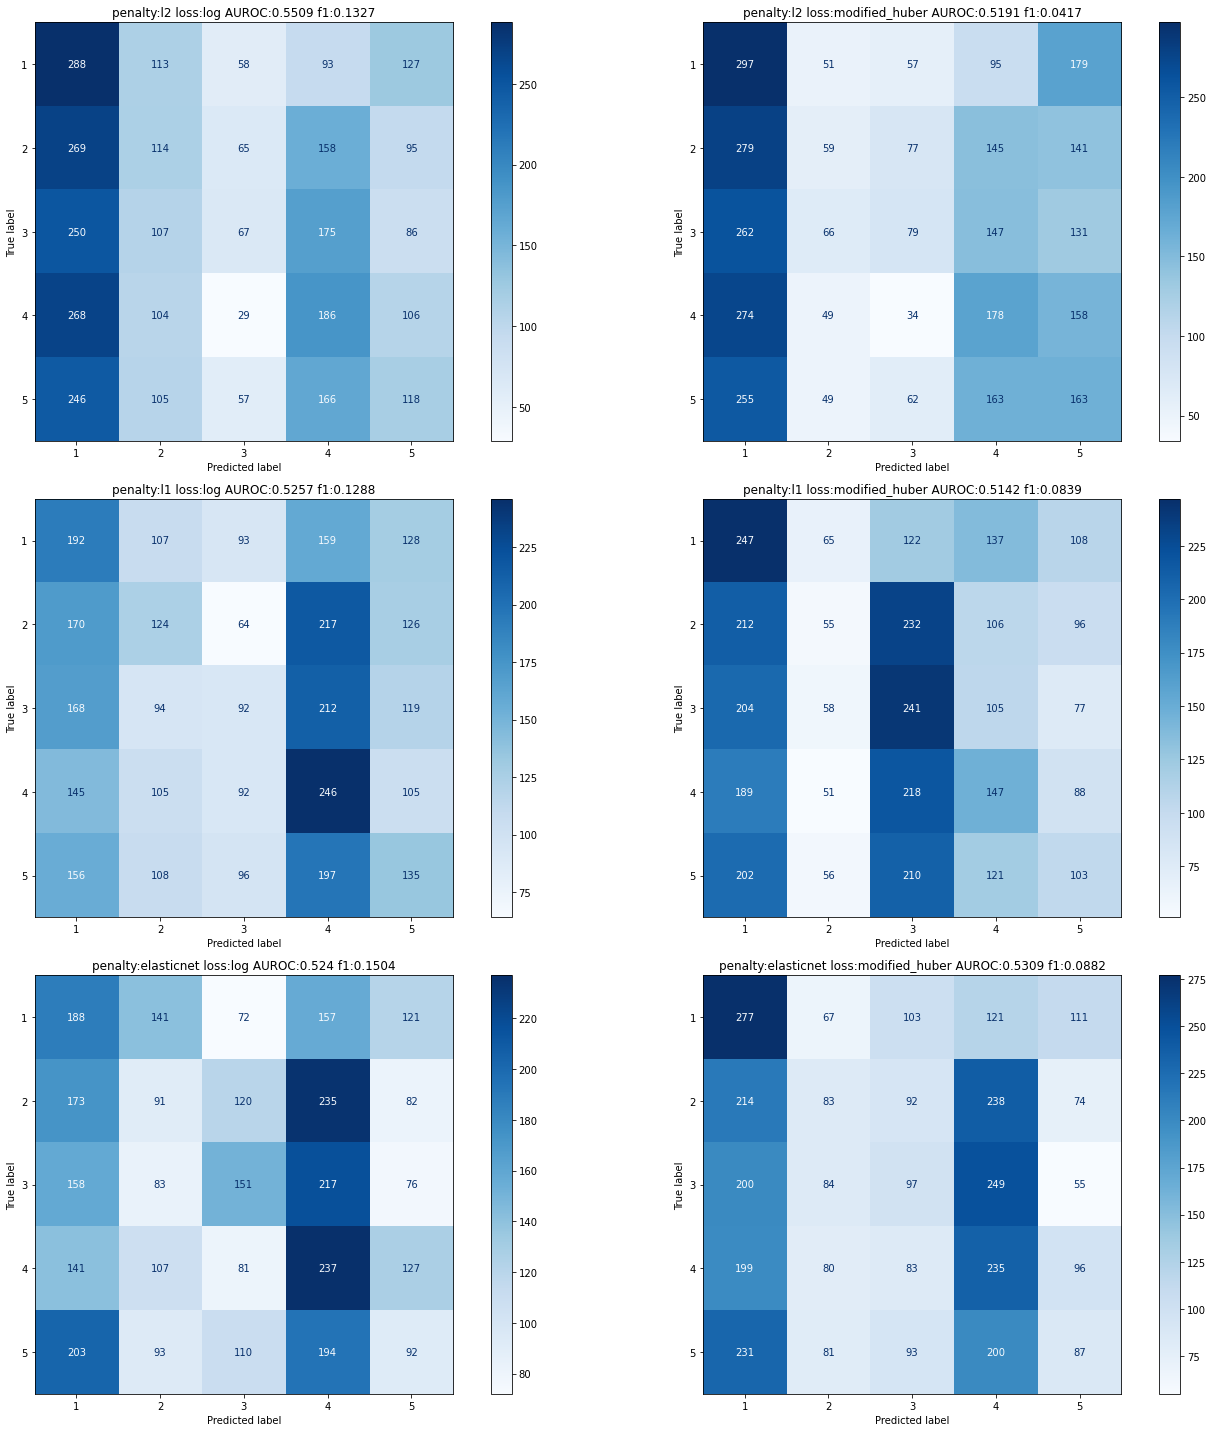

In [22]:
# SGD inferential 
evaluation_metrics(sgd_list, 3, 2, 'sgd')

In [23]:
#Logistic Regression best AUROC
# LR sag 0.005
lr_a = LogisticRegression(tol=0.1,
                        penalty='l2',
                        class_weight='balanced',
                        solver='sag',
                        C=0.005,
                        max_iter=100,
                        multi_class='multinomial',
                        verbose=False,
                        warm_start=False,
                        n_jobs=-1)

#Logistic Regression worst AUROC
# LR lbfg 1.0
lr_b = LogisticRegression(tol=0.1,
                        penalty='l2',
                        class_weight='balanced',
                        solver='lbfgs',
                        C=1.0,
                        max_iter=100,
                        multi_class='multinomial',
                        verbose=False,
                        warm_start=False,
                        n_jobs=-1)
        
# LogisticRegression class probabilities a
lra_pipe, lray_pred, lraflat_ypred = pos_proba(lr_a, X_train, y_train, X_test)

# LogisticRegression class probabilities b
lrb_pipe, lrby_pred, lrbflat_ypred = pos_proba(lr_b, X_train, y_train, X_test)

# Logistic Regression classification threshold
lra_auc, lra_fpr, lra_tpr = classOpVal(y_test, lray_pred, lraflat_ypred, lra_pipe)

# Logistic Regression classification threshold
lrb_auc, lrb_fpr, lrb_tpr = classOpVal(y_test, lrby_pred, lrbflat_ypred, lrb_pipe)

In [24]:
#Random Forest best AUROC
# RF entropy sqrt
rfa = RandomForestClassifier(n_estimators=100,
                            criterion="entropy",
                            max_depth=None,
                            min_samples_split=2,
                            max_features='sqrt',
                            bootstrap=True,
                            oob_score=True,
                            n_jobs=None,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            class_weight='balanced',
                            ccp_alpha=0.0,
                            max_samples=None)

#Random Forest worst AUROC
# RF gini log2
rfb = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            max_depth=None,
                            min_samples_split=2,
                            max_features='log2',
                            bootstrap=True,
                            oob_score=True,
                            n_jobs=None,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            class_weight='balanced',
                            ccp_alpha=0.0,
                            max_samples=None)
        
# Random Forest class probabilities a
rfa_pipe, rfay_pred, rfaflat_ypred = pos_proba(rfa, X_train, y_train, X_test)

# Random Forest class probabilities b
rfb_pipe, rfby_pred, rfbflat_ypred = pos_proba(rfb, X_train, y_train, X_test)

# Random Forest classification threshold
rfa_auc, rfa_fpr, rfa_tpr = classOpVal(y_test, rfay_pred, rfaflat_ypred, rfa_pipe)

# Random Forest classification threshold
rfb_auc, rfb_fpr, rfb_tpr = classOpVal(y_test, rfby_pred, rfbflat_ypred, rfb_pipe)

In [25]:
#AdaBoost best AUROC
# AB 1000 1
aba = AdaBoostClassifier(n_estimators=1000, 
                        learning_rate=1,
                        algorithm='SAMME.R',
                        random_state=0)

#AdaBoost worst AUROC
# AB 10 3
abb = AdaBoostClassifier(n_estimators=10, 
                        learning_rate=3,
                        algorithm='SAMME.R',
                        random_state=0)
        
# AdaBoost class probabilities a
aba_pipe, abay_pred, abaflat_ypred = pos_proba(aba, X_train, y_train, X_test)

# AdaBoost class probabilities b
abb_pipe, abby_pred, abbflat_ypred = pos_proba(abb, X_train, y_train, X_test)

# Adaboost classification threshold
aba_auc, aba_fpr, aba_tpr = classOpVal(y_test, abay_pred, abaflat_ypred, aba_pipe)

# Adaboost classification threshold
abb_auc, abb_fpr, abb_tpr = classOpVal(y_test, abby_pred, abbflat_ypred, abb_pipe)

In [26]:
#Linear Support Vector with SGD training best AUROC
# SGD log l2
sgd_a = SGDClassifier(loss='log',
                    penalty='l2', 
                    alpha=0.0001, 
                    l1_ratio=0.15, 
                    fit_intercept=True, 
                    max_iter=1000,
                    tol=0.001, 
                    shuffle=True, 
                    verbose=0, 
                    epsilon=0.1, 
                    n_jobs=-1, 
                    random_state=25, 
                    learning_rate='optimal', 
                    eta0=0.0, 
                    power_t=0.5, 
                    early_stopping=False, 
                    validation_fraction=0.1, 
                    n_iter_no_change=5, 
                    class_weight=None, 
                    warm_start=False, 
                    average=True)

#Linear Support Vector with SGD training worst AUROC
# SGD log elasticnet
sgd_b = SGDClassifier(loss='log',
                    penalty='elasticnet', 
                    alpha=0.0001, 
                    l1_ratio=0.15, 
                    fit_intercept=True, 
                    max_iter=1000,
                    tol=0.001, 
                    shuffle=True, 
                    verbose=0, 
                    epsilon=0.1, 
                    n_jobs=-1, 
                    random_state=25, 
                    learning_rate='optimal', 
                    eta0=0.0, 
                    power_t=0.5, 
                    early_stopping=False, 
                    validation_fraction=0.1, 
                    n_iter_no_change=5, 
                    class_weight=None, 
                    warm_start=False, 
                    average=True)

        
# SGD class probabilities a
sgda_pipe, sgday_pred, sgdaflat_ypred = pos_proba(sgd_a, X_train, y_train, X_test)

# SGD class probabilities b
sgdb_pipe, sgdby_pred, sgdbflat_ypred = pos_proba(sgd_b, X_train, y_train, X_test)

# SGD classification threshold
sgda_auc, sgda_fpr, sgda_tpr = classOpVal(y_test, sgday_pred, sgdaflat_ypred, sgda_pipe)

# SGD classification threshold
sgdb_auc, sgdb_fpr, sgdb_tpr = classOpVal(y_test, sgdby_pred, sgdbflat_ypred, sgdb_pipe)

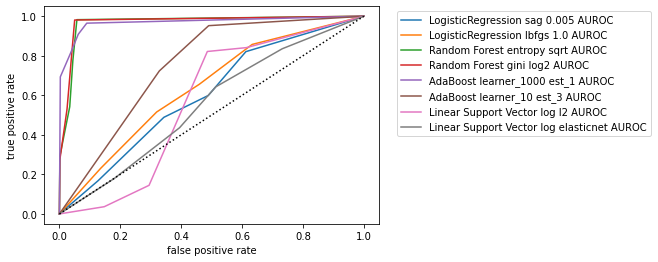

In [27]:
# AUROC Logistic Regression 
plt.plot(lra_tpr, lra_fpr, linestyle='-', label="LogisticRegression sag 0.005 AUROC" % lra_auc)

plt.plot(lrb_tpr, lrb_fpr, linestyle='-', label="LogisticRegression lbfgs 1.0 AUROC" % lrb_auc)

# AUROC Random Forest 
plt.plot(rfa_tpr, rfa_fpr, linestyle='-', label="Random Forest entropy sqrt AUROC" % rfa_auc)

plt.plot(rfb_tpr, rfb_fpr, linestyle='-', label="Random Forest gini log2 AUROC" % rfb_auc)

# AUROC AdaBoost 
plt.plot(aba_tpr, aba_fpr, linestyle='-', label="AdaBoost learner_1000 est_1 AUROC" % aba_auc)

plt.plot(abb_tpr, abb_fpr, linestyle='-', label="AdaBoost learner_10 est_3 AUROC" % abb_auc)

# AUROC SGD 
plt.plot(sgda_tpr, sgda_fpr, linestyle='-', label="Linear Support Vector log l2 AUROC" % sgda_auc)

plt.plot(sgdb_tpr, sgdb_fpr, linestyle='-', label="Linear Support Vector log elasticnet AUROC" % sgdb_auc)


#create diagonal line
plt.plot([0,1], [0,1], linestyle='dotted', linewidth=1.5, color='black')

# set axis labels
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

 
# display plot
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()